In [7]:
import sqlite3
db = sqlite3.connect('./database')
cursor = db.cursor()

In [ ]:
'gLength':('log(BP)',1,0.75,2),
                'cds_len':('log(BP)',1,0.75,2),
                'dn_ds':('dN/dS',1,0.5,2),
                'ess':('Degree of essentiality',1,0.75,2),
                'max_exp':('log(TPM)',1,0.75,2),
                'specificity':('tau',0.1,0.1,0.25),
                'motif_number_1k':('count',10,5,20),
                'PPIs':('log(count)',0.5,0.75,2,2200,2800),
#                 'gc_content':('%',5,5,20),
                'gc3':('%',10,7.5,30),
                'domains':('log(count)',0.5,0.75,2),
                'unique_domains':('count',2,1,4),
                'intron_count':('count',50,25,80),
                'avg_intron':('log(BP)',1,0.5,2),
#                 'intron_coverage':('%',10,10,30),
            'mis_Z_score':('score',5,2.5,8),
            'pLI_score':('score',0.1,2.5,8),
            'loftool_percentile':('score',5,2.5,8),
            's_het':('score',0.1,2.5,8),
            'Phi':('score',0.1,2.5,8),
            'RVIS':('score',10,2.5,8),
            'EvoTol':('score',5,2.5,8)}

In [490]:
# fetch and clean data: WGD vs Singleton model
# from pandas import DataFrame
# from numpy import log10
# from numpy import inf
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV
# import rfpimp
# from imblearn.under_sampling import RandomUnderSampler
# import pandas as pd
# import numpy as np

# print('imports done')

cursor.execute('''SELECT 
                   gLength, 
                   cds_len,
                   ess,
                   unique_domains, 
                   domains,
                   gc3,
                   motif_number_1k,
                   specificity, 
                   intron_count, 
                   avg_intron,
                   max_exp,
                   PPIs,
                   mis_Z_score,
                   pLI_score,
                   loftool_percentile,
                   s_het,
                   Phi,
                   RVIS,
                   EvoTol,
                   macaque_paralogs.dn_ds,
                   dup_type_T2
                FROM
                   gene_features
                   INNER JOIN
                   macaque_paralogs
                   ON
                   gene_features.id == macaque_paralogs.id
                WHERE
                   (dup_type_T2 == "WGD" OR dup_type_T2 == "singleton" OR dup_type_T2 == "singleton-ish")
                   AND EvoTol != "Not expressed above threshold in this ontology"''')

data = cursor.fetchall()
dfWGD = DataFrame(data).dropna()
dfWGD.columns = ['Genomic length','CDS length','Cellular essentiality','Unique domains','Domains','% GC3 content','Regulatory motifs','Specificity of Expression','Intron count','Average intron length','Max expression','PPIs','Missense Z score','pLI','LoFtool','S_het','Phi','RVIS','EvoTol','Evolution rate','dupType']
dfWGD = dfWGD.replace(to_replace='singleton-ish',value='singleton')



dfWGD['Genomic length'] = log10(dfWGD['Genomic length'])
dfWGD['CDS length'] = log10(dfWGD['CDS length'])
dfWGD['Average intron length'] = log10(dfWGD['Average intron length'])
dfWGD['Max expression'] = log10(dfWGD['Max expression'])
dfWGD['Average intron length'] = dfWGD['Average intron length'].replace(to_replace=-(np.inf),value=0)

# remove negative importance variables
# dfWGD = dfWGD.drop(['% GC content','% GC3 content','Transcript isoforms count','Regulatory motifs','Average intron length'],axis=1)


/Users/zoevance/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


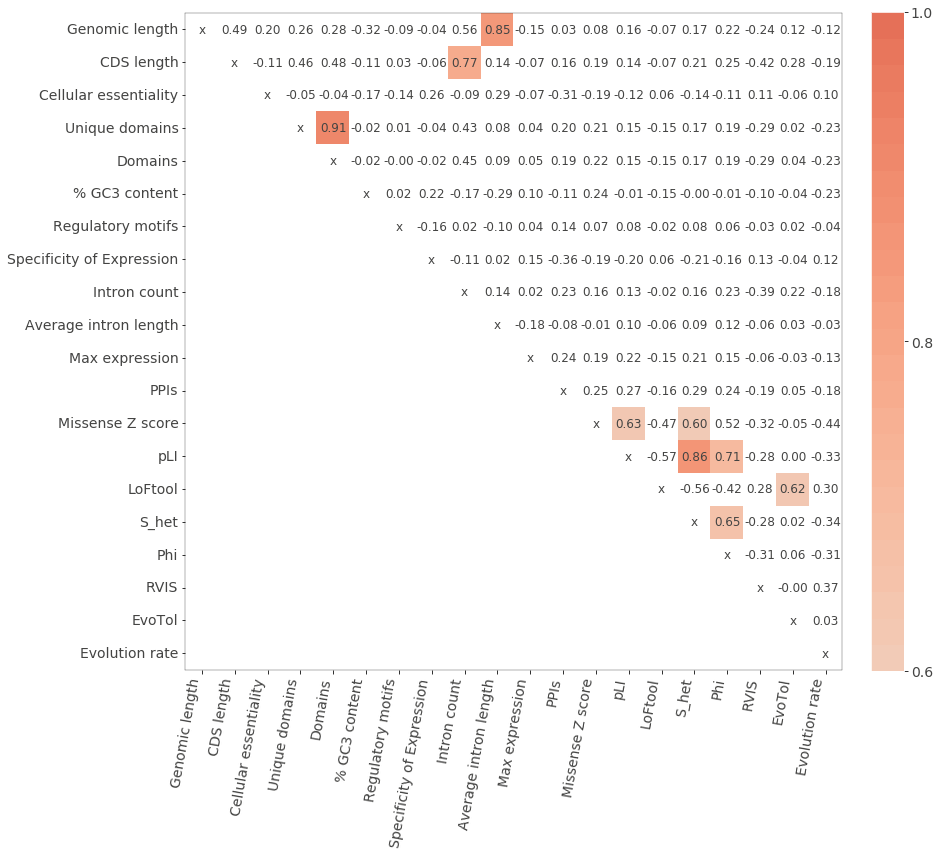

In [491]:
# maybe check for collinearity/codependence at this stage: PCA? Or look at sums of raw scores? - whole set
# this is the raw data
viz = rfpimp.plot_corr_heatmap(dfWGD.iloc[:,0:20],figsize=(13,12),label_fontsize=14,value_fontsize=12)
viz.save('corr_WGD_Sing_new_round1.svg')
viz.view()

# mat = rfpimp.feature_dependence_matrix(dfWGD.iloc[:,0:20])
# viz2 = rfpimp.plot_dependence_heatmap(mat,figsize=[15,10],label_fontsize=13,value_fontsize=10)
# viz2.save('dep_WGD_Sing_new_round1.svg')
# viz2.view()

In [492]:
# dimensionality reduction
from sklearn.decomposition import PCA

pcadfWGD1 = dfWGD[['Genomic length','Average intron length']]
pcadfWGD2 = dfWGD[['CDS length','Intron count']]

pcadfWGD4 = dfWGD[['Missense Z score','pLI','S_het','Phi']]
pcadfWGD5 = dfWGD[['LoFtool','EvoTol']]
pcadfWGD6 = dfWGD[['Domains','Unique domains']]

pca = PCA(n_components=2)
pca.fit(pcadfWGD1)
# DataFrame(pca.explained_variance_ratio_)
pca1trans = DataFrame(pca.transform(pcadfWGD1))
pca1trans.columns = ['Genomic length and avg intron length 1','Genomic length and avg intron length 2']
pca1trans

pca = PCA(n_components=1)
pca.fit(pcadfWGD2)
pca2trans = DataFrame(pca.transform(pcadfWGD2))
pca2trans.columns = ['CDS length and intron count']
pca2trans

pca = PCA(n_components=2)
pca.fit(pcadfWGD4)
pca4trans = DataFrame(pca.transform(pcadfWGD4))
pca4trans.columns = ['Missense Z, pLI, Shet, Phi 1','Missense Z, pLI, Shet, Phi 2']
pca4trans
pca = PCA(n_components=1)
pca.fit(pcadfWGD5)
pca5trans = DataFrame(pca.transform(pcadfWGD5))
pca5trans.columns = ['EvoTol and LoFtool']
pca5trans
pca = PCA(n_components=1)
pca.fit(pcadfWGD6)
pca.explained_variance_ratio_
pca6trans = DataFrame(pca.transform(pcadfWGD6))
pca6trans.columns = ['Domains - Unique domains']
pca6trans
# p = pca.transform(pcadfWGD)
# p = DataFrame(p)
# DataFrame(pca.explained_variance_ratio_)

,Domains - Unique domains
0,-1.356003
1,9.319437
2,-0.103709
3,-1.356003
4,-1.356003
5,-2.608298
6,-0.401315
7,-1.356003
8,-1.356003
9,-1.356003


In [119]:
# for checking which element the PC correlates with
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],p['PC2']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('EvoTol', -0.99771582642352807),
 ('LoFtool', -0.63231464651643454),
 ('CDS length', -0.27428357677374166),
 ('Intron count', -0.21299674040861827),
 ('Genomic length', -0.12053054880978242),
 ('Missense Z score', 0.072012921325596072),
 ('Transcript isoforms count', -0.063905052277933361),
 ('RVIS', -0.05692931363984205),
 ('Evolution rate', -0.056797257883818286),
 ('Intron coverage', -0.052646804788778992),
 ('% GC3 content', 0.049620419344244132),
 ('Essentiality', 0.048860333064598131),
 ('Phi', -0.042062243499829274),
 ('Domains', -0.036173868069631798),
 ('Max expression', 0.035367646853199215),
 ('PPIs', -0.034925466349469983),
 ('Specificity of Expression', 0.027564251897539329),
 ('Average intron length', -0.026443540522434882),
 ('% GC content', 0.024984222428022479),
 ('Regulatory motifs', -0.018336507935710334),
 ('pLI', 0.014148592647934801),
 ('Unique domains', -0.012694541675316501),
 ('S_het', -0.001306972338092253)]

In [493]:
# making a shiny new dataframe with (hopefully) no multicollinearity
combiDF = DataFrame(pca1trans)
combiDF = combiDF.join(pca2trans)
# combiDF = combiDF.join(pca3trans)
combiDF = combiDF.join(pca4trans)
combiDF = combiDF.join(pca5trans)
combiDF = combiDF.join(pca6trans)
combiDF = combiDF.join(dfWGD['% GC3 content'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['Cellular essentiality'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['Regulatory motifs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['Specificity of Expression'].reset_index().drop('index',axis=1))
# combiDF = combiDF.join(dfWGD['Transcript isoforms count'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['Max expression'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['PPIs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['RVIS'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['Evolution rate'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(dfWGD['dupType'].reset_index().drop('index',axis=1))
combiDF

,Genomic length and avg intron length 1,Genomic length and avg intron length 2,CDS length and intron count,"Missense Z, pLI, Shet, Phi 1","Missense Z, pLI, Shet, Phi 2",EvoTol and LoFtool,Domains - Unique domains,% GC3 content,Cellular essentiality,Regulatory motifs,Specificity of Expression,Max expression,PPIs,RVIS,Evolution rate,dupType
0,0.078859,-0.114138,-6.911736,-0.793436,-0.222420,-24.335059,-1.356003,0.549223,-0.439,0.0,0.934283,2.373923,2,53.25,0.81803,singleton
1,-0.378103,0.126653,4.096414,-0.262018,-0.418235,44.860372,9.319437,0.660256,-0.139,0.0,0.880997,2.534407,21,26.40,0.13543,WGD
2,-0.119245,-0.142013,-5.912230,-1.347203,-0.194571,-32.963518,-0.103709,0.641711,-1.270,0.0,0.714035,1.633468,10,54.71,0.16535,singleton
3,-0.204961,-0.010893,-1.910465,-0.373246,-0.423649,-16.982642,-1.356003,0.506986,0.022,0.0,0.706698,1.361728,16,16.18,0.24643,singleton
4,-0.306253,0.116172,3.096568,-0.148114,-0.472346,0.098172,-1.356003,0.592742,-0.429,12.0,0.567309,1.602060,7,75.92,0.36295,singleton
5,-0.308079,-0.129417,-5.905409,1.895343,-0.152018,38.421756,-2.608298,0.464508,-0.349,0.0,0.708350,2.060698,48,13.66,0.10677,WGD
6,-0.584890,0.215131,9.092942,0.851554,0.702074,24.726319,-0.401315,0.339286,-0.037,16.0,0.893005,2.392521,51,75.46,0.12339,singleton
7,-0.163338,0.095961,4.092022,-1.069980,-0.293949,43.749963,-1.356003,0.385321,-0.481,0.0,0.758026,1.959041,5,8.72,0.06507,WGD
8,0.477224,-0.287954,-6.921314,-2.485147,0.353223,25.103257,-1.356003,0.439394,-0.165,13.0,0.823639,2.029384,0,79.13,0.83857,singleton
9,0.735096,0.021158,4.091380,0.710246,0.758709,-28.003895,-1.356003,0.556338,-0.315,4.0,0.593118,2.086004,160,35.57,0.10536,singleton


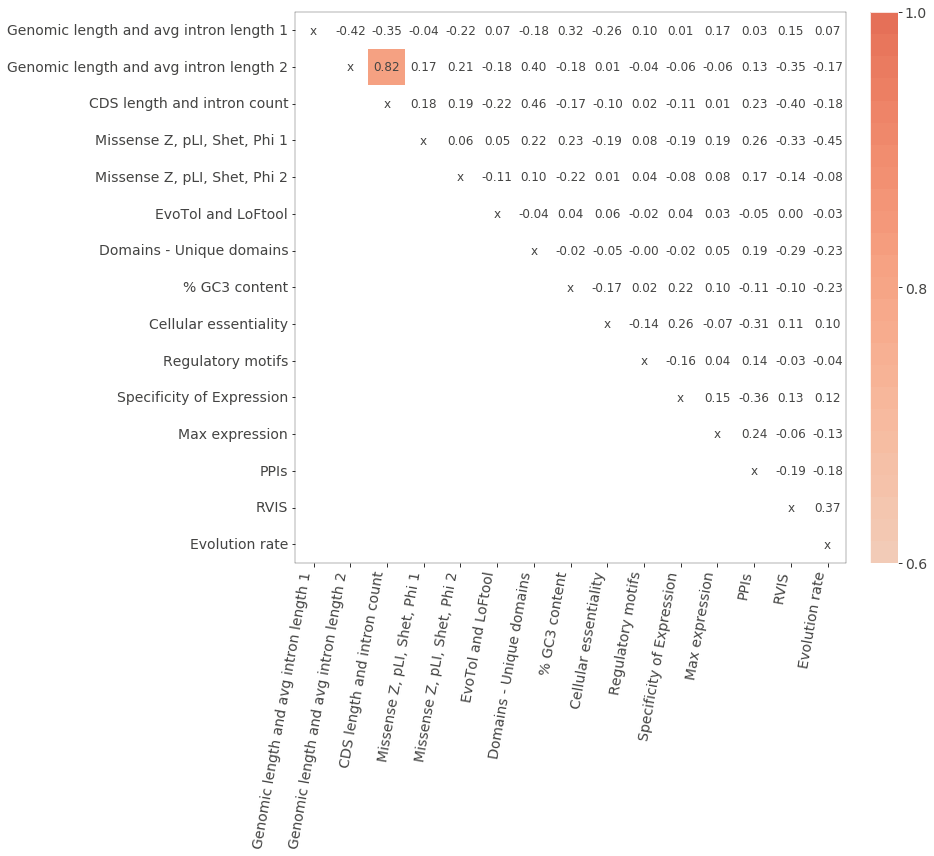

In [494]:
# maybe check for collinearity/codependence at this stage: PCA? Or look at sums of raw scores? - initial PCA
# this is PCA'd data
viz = rfpimp.plot_corr_heatmap(combiDF.iloc[:,0:15],figsize=(13,12),label_fontsize=14,value_fontsize=12)
viz.save('corr_WGD_Sing_new_round1_PCA.svg')
viz.view()

# mat = rfpimp.feature_dependence_matrix(combiDF.iloc[:,0:16])
# viz2 = rfpimp.plot_dependence_heatmap(mat,figsize=[15,10],label_fontsize=13,value_fontsize=10)
# viz2.save('dep_WGD_Sing_new_round1_PCA.svg')
# viz2.view()

In [ ]:
#### let's try that again.. - second PCA based on what kind of mess the first one gives - not run
pcaDF1 = df[['Genomic length','Average intron length','Intron coverage','CDS length','Intron count',
             '% GC content','% GC3 content','Transcript isoforms count','Domains','Unique domains']]
pcaDF4 = df[['Missense Z score','pLI','S_het','Phi']]
pcaDF5 = df[['LoFtool','EvoTol']]

pca = PCA(n_components=3)
pca.fit(pcaDF1)
# print(DataFrame(pca.explained_variance_ratio_))
pca1trans = DataFrame(pca.transform(pcaDF1))
pca1trans.columns = ['Genomic_Avg_Int_Int_Cov1','Genomic_Avg_Int_Int_Cov2','Genomic_Avg_Int_Int_Cov3']

pca = PCA(n_components=2)
pca.fit(pcaDF4)
pca4trans = DataFrame(pca.transform(pcaDF4))
pca4trans.columns = ['MissZ_pLI_Shet_Phi1','MissZ_pLI_Shet_Phi2']
# pca4trans

pca = PCA(n_components=1)
pca.fit(pcaDF5)
pca5trans = DataFrame(pca.transform(pcaDF5))
pca5trans.columns = ['EvoTol_LoFtool']
# pca5trans

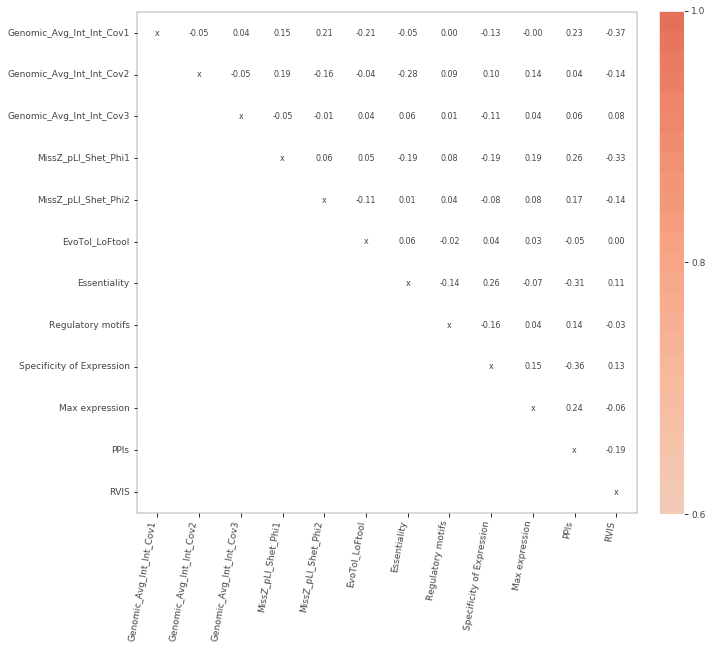

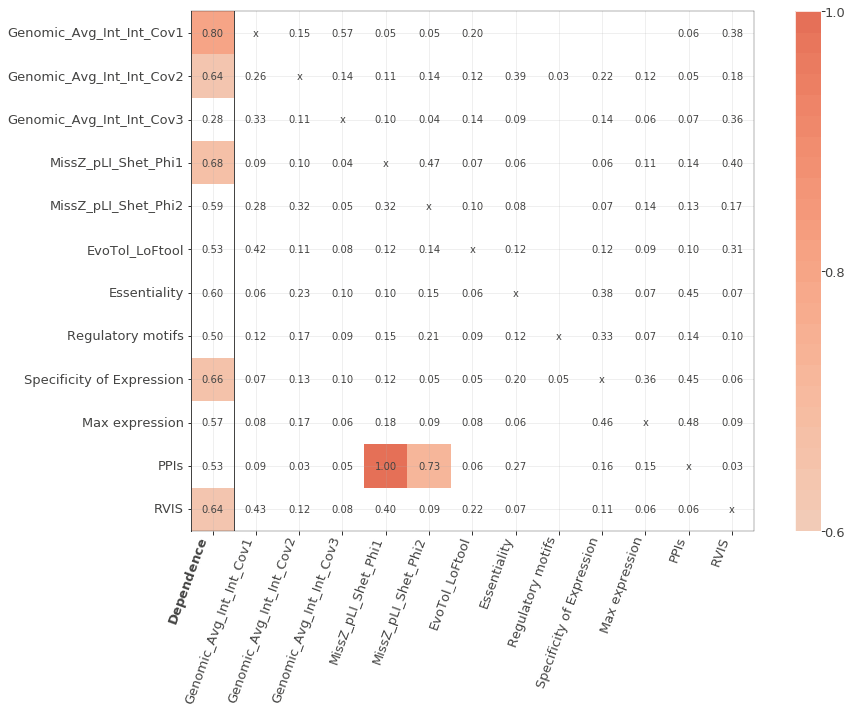

In [250]:
# EXTRA shiny new dataframe - not run
combiDF = DataFrame(pca1trans)
combiDF = combiDF.join(pca4trans)
combiDF = combiDF.join(pca5trans)
combiDF = combiDF.join(df['Essentiality'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Regulatory motifs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Specificity of Expression'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Max expression'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['PPIs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['RVIS'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Evolution rate'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['dupType'].reset_index().drop('index',axis=1))

viz = rfpimp.plot_corr_heatmap(combiDF.iloc[:,0:12],figsize=(10,10))
viz.save('corr_WGD_Sing_new_round1_PCA2.svg')
viz.view()

mat = rfpimp.feature_dependence_matrix(combiDF.iloc[:,0:12])
viz2 = rfpimp.plot_dependence_heatmap(mat,figsize=[15,10],label_fontsize=13,value_fontsize=10)
viz2.save('dep_WGD_Sing_new_round1_PCA2.svg')
viz2.view()

In [437]:
# test/train splitting
train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:12]], combiDFBinary[combiDFBinary.columns[12]], train_size = 0.8)

# undersampling/weighting/oversampling - all in one cell for easy switching
# undersampling
sampler = RandomUnderSampler()
train_X, train_Y  = sampler.fit_sample(train_x, train_y)

# no optimisation fit and accuracy check
rf = RandomForestClassifier()
rf.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rf.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rf.predict(test_x)))
print('F1 score: ', f1_score(test_y,rf.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/imblearn/utils/validation.py:77: UserWarning: 'y' should be of types ('binary', 'multiclass') only. Got continuous instead.
  TARGET_KIND, type_of_target(y)))


ValueError: Unknown label type: 'continuous'

In [451]:
# run with PCA'd set
# test/train splitting
combiDFBinary = combiDF.replace('WGD',1)
combiDFBinary = combiDFBinary.replace('singleton',0)
train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:15]], combiDFBinary[combiDFBinary.columns[15]], train_size = 0.8)

# undersampling/weighting/oversampling - all in one cell for easy switching
# undersampling
sampler = RandomUnderSampler()
train_X, train_Y  = sampler.fit_sample(train_x, train_y)
# no optimisation fit and accuracy check
rf = RandomForestClassifier()
rf.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rf.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rf.predict(test_x)))
print('F1 score: ', f1_score(test_y,rf.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

# hyperparameter selection - initial broad search followed by fine tuning
# broad search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2,n_jobs = -1,scoring='f1')
# Fit the random search model
rf_random.fit(train_X, train_Y)
print(rf_random.best_params_)

/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Overall accuracy: 0.63315696649
F1 score:  0.514018691589

Singleton recall: 0.516431924883
Singleton precision: 0.511627906977

WGD recall: 0.703389830508
WGD precision: 0.707386363636
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100 
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100, total=   1.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100, total=   1.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=4, max_featu

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.3s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   3.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   3.3s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=4, ma

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.0s


[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   3.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=150, total=   3.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150, total=   2.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150, total=   2.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=150 
[CV]  min_samples_leaf=1, max_feat

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.7s
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.8s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116, total=   2.6s
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116, total=   2.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, ma

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133, total=   1.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133, total=   1.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=2, n_estimators=133, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, 

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83, total=   2.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=2, n_estimators=83 
[CV]  min_samples_leaf=1, max_featur

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min


[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=17, total=   0.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50, total=   0.7s
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50, total=   0.7s
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50 
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50, total=   0.7s
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=10, n_estimators=50, total=   0.7s
[CV] min_samp

[CV] min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100 
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=sqrt, max_de

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=1 
[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=67, total=   1.3s
[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=67, total=   1.2s
[CV] min_samples_leaf=2, max_features

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.7s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.7s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=116, total=   1.6s
[CV] min_samples_lea

[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67, total=   1.3s
[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, min_samples_split=2, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=10, n_estimators=67, total=   1.1s
[CV] min_samples_leaf

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.2s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.2s
[CV] min_samples_leaf=2, max_feature

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.0min


[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100, total=   1.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100, total=   1.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100, total=   1.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=5, n_estimators=100 
[CV]  min_samples_leaf=1, max_featur

[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116, total=   2.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116, total=   2.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116, total=   1.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=2, n_estimators=116, total=   1.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=4, ma

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150, total=   1.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150, total=   1.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150, total=   1.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150, total=   1.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_le

[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] min_samples_leaf=1, max

[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt,

[CV] min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=True, min_samples_split=5, n_estimators=116, total=   1.3s
[CV] min_samples_leaf=1, max_feature

[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=10, n_estimators=34 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=10, n_estimators=34, total=   0.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=10, n_estimators=34 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=10, n_estimators=34, total=   0.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=83 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=10, n_estimators=34, total=   0.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=83 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=83, total=   0.8s
[CV] min_samples_leaf=4, max_featu

[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150, total=   2.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150, total=   2.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150, total=   2.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150, total=   2.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=150 
[CV]  min_samples_le

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=sqr

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  7.1min


[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=1, ma

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=17, total=   0.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=17, total=   0.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=17 
[CV]  min_samples_leaf=1, max_featur

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83, total=   0.8s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83, total=   0.8s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83, total=   0.8s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=10, n_estimators=83, total=   0.8s
[CV] min_samples_leaf=2, max_feature

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=1, total=   0.0s
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=1 
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=1, total=   0.0s
[CV]  min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=auto,

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.1s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, min_samples_split=5, n_estimators=150, total=   2.1s
[CV] min_samples_leaf=2, max

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67, total=   0.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67, total=   0.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67, total=   0.9s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=5, n_estimators=67, total=   0.9s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=67 
[CV]  min_samples_leaf=2, max_feat

[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100, total=   1.0s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100, total=   1.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100, total=   1.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=100 
[CV]  min_samples_le

[CV] min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116, total=   1.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116, total=   1.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116, total=   1.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=116, total=   1.1s
[CV] min_samples_leaf=2, max_feature

[CV] min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True, min_samples_split=10, n_estimators=17 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True, min_samples_split=10, n_estimators=17, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=1, max_features=auto

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.4s
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.3s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.1s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.1s
[CV] min_samples_leaf=2, max

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.0s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.0s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.0s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, min_samples_split=2, n_estimators=17 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=83, total=   1.0s
[CV] min_samples_leaf=2, max_f

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished


{'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True, 'min_samples_split': 10, 'n_estimators': 150}


In [452]:
# PCA'd data, after broad search
from sklearn.metrics import f1_score
rfBestWGD = rf_random.best_estimator_
rfBestWGD.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestWGD.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestWGD.predict(test_x)))
print('F1 score: ',f1_score(test_y,rfBestWGD.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

Overall accuracy: 0.683421516755
F1 score:  0.627206645898

Singleton recall: 0.708920187793
Singleton precision: 0.562383612663

WGD recall: 0.668079096045
WGD precision: 0.79229480737


In [453]:
# PCA
# more refined search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 125, stop = 175, num = 25)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(7,20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2,n_jobs = -1,scoring='f1')
# Fit the random search model
rf_random.fit(train_X, train_Y)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158 
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=158, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=

[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.3s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125 
[CV]  min_samples_leaf=2, max_featur

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.1s


[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.2s
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170 
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170, total=   1.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170, total=   1.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=170 
[CV]  min_samples_

[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=15, bootstrap=False, min_samples_split=10, n_estimators=135 
[CV]  min_samples_le

[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152, total=   2.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152, total=   2.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152, total=   1.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=133 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=152, total=   1.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=133 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141, total=   1.4s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141, total=   1.4s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141, total=   1.3s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141, total=   1.2s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=8, bootstrap=True, min_samples_split=10, n_estimators=141 
[CV]  min_samples_leaf=2, max_featur

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.4min


[CV]  min_samples_leaf=2, max_features=auto, max_depth=8, bootstrap=False, min_samples_split=10, n_estimators=125, total=   2.0s
[CV] min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=8, bootstrap=False, min_samples_split=10, n_estimators=125, total=   2.0s
[CV] min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147, total=   1.4s
[CV] min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147, total=   1.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=147 
[CV]  min_samples_leaf=1, max_features=a

[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168, total=   2.0s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168, total=   2.0s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168, total=   1.8s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168, total=   1.8s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=False, min_samples_split=2, n_estimators=168 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162, total=   1.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162, total=   1.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=False, min_samples_split=10, n_estimators=143 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=5, n_estimators=162, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=False, min_samples_split=10, n_estimators=143 
[CV]  min_samples_leaf=4, max_fe

[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_sam

[CV] min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172, total=   1.8s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172, total=   1.8s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172, total=   1.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=8, bootstrap=False, min_samples_split=2, n_estimators=172, total=   1.8s
[CV] min_samples_leaf=4, max_feature

[CV] min_samples_leaf=4, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=175 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=175, total=   2.1s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=175, total=   1.9s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.1s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.0s
[CV] min_samp

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.6min


[CV]  min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131, total=   2.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131, total=   2.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131, total=   2.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131, total=   2.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=5, n_estimators=131 
[CV]  min_samples_leaf=1, ma

[CV]  min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152, total=   1.8s
[CV] min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=11, bootstrap=False, min_samples_split=10, n_estimators=152, total=   1.8s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=160 
[CV]  min_samples_leaf

[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, min_samples_split=2, n_estimators=129, total=   1.7s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=1, max_featu

[CV]  min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, ma

[CV]  min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, min_samples_split=10, n_estimators=175, total=   2.3s
[CV] min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, min_samples_split=10, n_estimators=175 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, min_samples_split=10, n_estimators=175, total=   2.7s
[CV] min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=154 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, min_samples_split=10, n_estimators=175, total=   3.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=154 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=154, total=   2.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=154 
[CV]  min_samples_leaf=4

[CV]  min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=5, n_estimators=125 
[CV]  min_samples_leaf=2, max_featur

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=15, bootstrap=True, min_samples_split=10, n_estimators=168, total=   1.7s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=9, bootstrap=True, min_samples_split=2, n_estimators=166 
[CV]  min_samples_leaf=2, max_

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=2, n_estimators=133, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162, total=   2.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162, total=   2.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162, total=   2.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=5, n_estimators=162 
[CV]  min_sampl

[CV]  min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, min_samples_split=2, n_estimators=162 
[CV]  min_samples_leaf=4, max_featur

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 10.1min


[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127, total=   1.3s
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127, total=   1.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127 
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=10, n_estimators=127 
[CV]  min_samples_leaf=1, ma

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158, total=   2.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=False, min_samples_split=10, n_estimators=158 
[CV]  min_samples_le

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170, total=   2.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170, total=   2.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=170 
[CV]

[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=9, bootstrap=True, min_samples_split=10, n_estimators=135 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=2, n_estimators=145, total=   1.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=9, bootstrap=True, min_samples_split=10, n_estimators=135 
[CV]  min_samples_leaf=1, max_featur

[CV]  min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147, total=   1.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147, total=   1.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=14, bootstrap=True, min_samples_split=10, n_estimators=147 
[CV]  min_samples_leaf=4, ma

[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=15, bootstrap=True, min_samples_split=2, n_estimators=156 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=True, min_samples_split=10, n_estimators=152, total=   1.2s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=True, min_samples_split=10, n_estimators=152, total=   1.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=164 
[CV]  min_samples_leaf=1, max_featur

[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145, total=   1.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145, total=   1.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145, total=   1.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145, total=   1.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=9, bootstrap=True, min_samples_split=5, n_estimators=145 
[CV]  min_samples_leaf=4, max_features=auto,

[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=137 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, min_samples_split=5, n_estimators=164, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=11, bootstrap=True, min_samples_split=2, n_estimators=137 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156, total=   1.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=17, bootstrap=True, min_samples_split=5, n_estimators=156 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=145 
[CV]  min_sa

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.3min finished


{'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': False, 'min_samples_split': 2, 'n_estimators': 168}


In [454]:
# PCA'd data, after refined search
rfBestWGD = rf_random.best_estimator_
rfBestWGD.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestWGD.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestWGD.predict(test_x)))
print('F1 score: ',f1_score(test_y,rfBestWGD.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

Overall accuracy: 0.679894179894
F1 score:  0.627692307692

Singleton recall: 0.718309859155
Singleton precision: 0.55737704918

WGD recall: 0.656779661017
WGD precision: 0.794871794872


In [455]:
# current best WGD model parameters
print(rfBestWGD)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=168, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [456]:
# initial run: look for negative importances: refined 1st run
rfBestWGD = rf_random.best_estimator_
print(rfBestWGD)

rfBestWGD.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestWGD.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestWGD.predict(test_x)))
print('Singleton accuracy:', tp/(tp+fn))
print('WGD accuracy:', tn/(tn+fp))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=168, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Overall accuracy: 0.683421516755
Singleton accuracy: 0.732394366197
WGD accuracy: 0.65395480226


In [467]:
# check feature importances for selected hyperparameters: PCA'd data
rankingDict = {}
for feature in combiDFBinary.columns[:15]:
    rankingDict[feature] = []
impDict = {}
for feature in combiDFBinary.columns[:15]:
    impDict[feature] = []
impDict['Sum Gen. length 2/CDS length'] = []
rankingDict['Sum Gen. length 2/CDS length'] = []
for i in range(10):
    sampler = RandomUnderSampler()
    train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:15]], combiDFBinary[combiDFBinary.columns[15]], train_size = 0.8)
    train_X, train_Y  = sampler.fit_sample(train_x, train_y)

    rfBestWGD.fit(train_X,train_Y)
     
    imps = list(rfpimp.importances(rfBestWGD,test_x,test_y).itertuples(name=None))
    imps.append(('Sum Gen. length 2/CDS length', sum([x[1] for x in imps if x[0] == 'Genomic length and avg intron length 2' or x[0] == 'CDS length and intron count'])))
    imps = sorted(imps,key= lambda x: x[1],reverse=True)
    feats = list(combiDFBinary.columns[:15])
    feats.append('Sum Gen. length 2/CDS length')
    for feature in feats:
        rank = [x[0] for x in imps].index(feature) + 1
        rankingDict[feature].append(rank)
        impDict[feature].append([x[1] for x in imps if x[0] == feature][0])
rankDict = {'Genomic length and avg intron length 1':[], 'Genomic length and avg intron length 2':[],
            'CDS length and intron count':[], 'Missense Z, pLI, Shet, Phi 1':[], 'Missense Z, pLI, Shet, Phi 2':[], 
            'EvoTol and LoFtool':[],'Domains - Unique domains':[], '% GC3 content':[],
       'Cellular essentiality':[], 'Regulatory motifs':[], 'Specificity of Expression':[],
       'Max expression':[], 'PPIs':[], 'RVIS':[], 'Evolution rate':[],'Sum Gen. length 2/CDS length':[]}
for f in rankingDict:
    rankDict[f].append(np.mean(rankingDict[f]))
    rankDict[f].append(np.std(rankingDict[f]))
print(rankDict)
print('')
for f in impDict:
    print(f, np.mean(impDict[f]))

/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_siz

{'Domains - Unique domains': [10.6, 3.3226495451672302], 'EvoTol and LoFtool': [11.9, 3.3000000000000003], 'Missense Z, pLI, Shet, Phi 1': [2.6000000000000001, 1.2], '% GC3 content': [9.9000000000000004, 4.0607881008493907], 'Genomic length and avg intron length 1': [8.9000000000000004, 3.4770677301427422], 'CDS length and intron count': [12.300000000000001, 3.2878564445547189], 'Specificity of Expression': [4.5999999999999996, 2.8354893757515653], 'Evolution rate': [1.8999999999999999, 0.94339811320566036], 'Sum Gen. length 2/CDS length': [10.6, 3.4985711369071804], 'Missense Z, pLI, Shet, Phi 2': [8.3000000000000007, 3.1000000000000001], 'Max expression': [9.5999999999999996, 2.4166091947189146], 'Genomic length and avg intron length 2': [10.5, 3.8013155617496426], 'Cellular essentiality': [1.8, 0.40000000000000002], 'PPIs': [11.1, 2.3853720883753127], 'Regulatory motifs': [12.6, 2.0099751242241783], 'RVIS': [8.8000000000000007, 3.4583232931581169]}

Domains - Unique domains 0.004409

In [469]:
# fetch and clean data: SSD vs Singleton model
# from pandas import DataFrame
# from numpy import log10
# from numpy import inf
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import RandomizedSearchCV
# import rfpimp
# from imblearn.under_sampling import RandomUnderSampler
# import pandas as pd
import numpy as np

# print('imports done')

cursor.execute('''SELECT 
                   gLength, 
                   cds_len,
                   ess,
                   unique_domains, 
                   domains,
                
                   gc3,
                   motif_number_1k,
                   specificity,
                    
                   intron_count, 
                   avg_intron,
                   
                   max_exp,
                   PPIs,
                   mis_Z_score,
                   pLI_score,
                   loftool_percentile,
                   s_het,
                   Phi,
                   RVIS,
                   EvoTol,
                   macaque_paralogs.dn_ds,
                   dup_type_T2
                FROM
                   gene_features
                   INNER JOIN
                   macaque_paralogs
                   ON
                   gene_features.id == macaque_paralogs.id
                WHERE
                   (dup_type_T2 == "SSD" OR dup_type_T2 == "singleton" OR dup_type_T2 == "singleton-ish")
                   AND EvoTol != "Not expressed above threshold in this ontology"''')

data = cursor.fetchall()
df = DataFrame(data).dropna()
df.columns = ['Genomic length','CDS length','Essentiality','Unique domains','Domains','% GC3 content','Regulatory motifs','Specificity of Expression','Intron count','Average intron length','Max expression','PPIs','Missense Z score','pLI','LoFtool','S_het','Phi','RVIS','EvoTol','Evolution rate','dupType']
df = df.replace(to_replace='singleton-ish',value='singleton')



df['Genomic length'] = log10(df['Genomic length'])
df['CDS length'] = log10(df['CDS length'])
df['Average intron length'] = log10(df['Average intron length'])
df['Max expression'] = log10(df['Max expression'])
df['Average intron length'] = df['Average intron length'].replace(to_replace=-(np.inf),value=0)

# remove negative importance variables
# df = df.drop(['% GC content','% GC3 content','Transcript isoforms count','Regulatory motifs','Average intron length'],axis=1)


/Users/zoevance/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


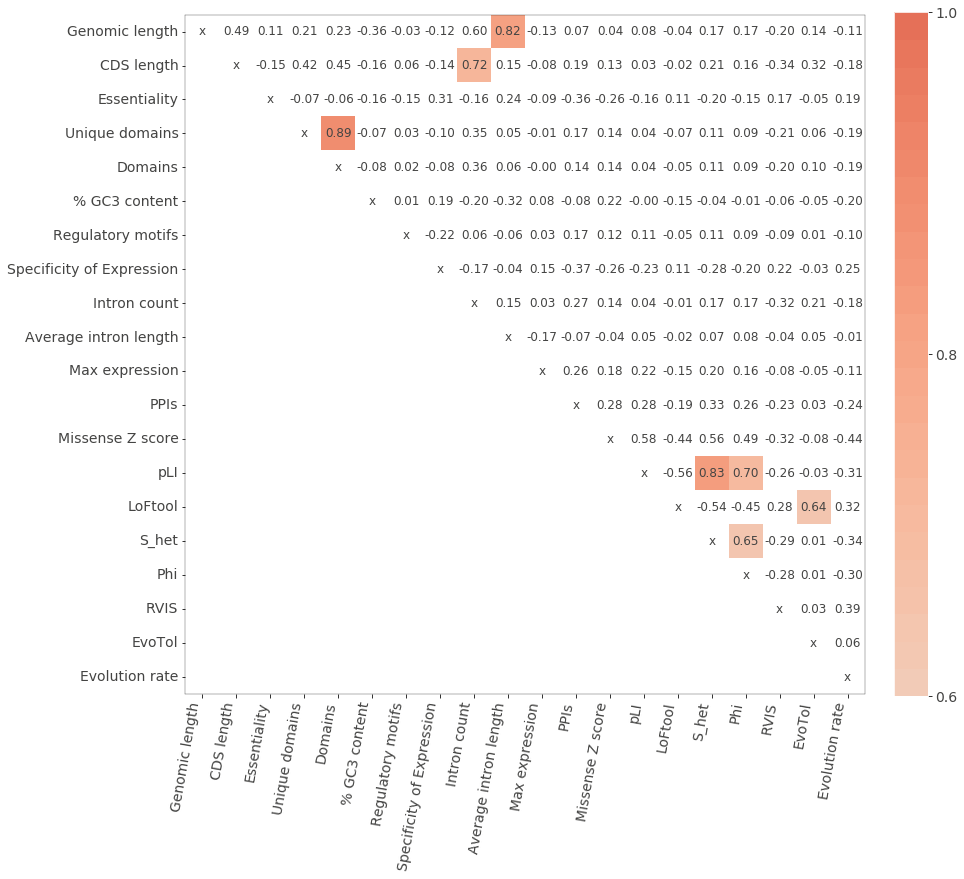

In [471]:
# maybe check for collinearity/codependence at this stage: PCA? Or look at sums of raw scores? - initial PCA
# this is PCA'd data
viz = rfpimp.plot_corr_heatmap(df.iloc[:,0:20],figsize=(13.5,13.5),label_fontsize=14,value_fontsize=12)
viz.save('corr_SSD_Sing_new_round1.svg')
viz.view()

# mat = rfpimp.feature_dependence_matrix(df.iloc[:,0:23])
# viz2 = rfpimp.plot_dependence_heatmap(mat,figsize=[15,10],label_fontsize=13,value_fontsize=10)
# viz2.save('dep_SSD_Sing_new_round1.svg')
# viz2.view()

In [473]:
# dimensionality reduction
from sklearn.decomposition import PCA

pcaDF1 = df[['Genomic length','Average intron length']]
pcaDF2 = df[['CDS length','Intron count']]
# pcaDF3 = df[['% GC content','% GC3 content']]
pcaDF4 = df[['Missense Z score','pLI','S_het','Phi']]
pcaDF5 = df[['LoFtool','EvoTol']]
pcaDF6 = df[['Domains','Unique domains']]

pca = PCA(n_components=2)
pca.fit(pcaDF1)
DataFrame(pca.explained_variance_ratio_)
pca1trans = DataFrame(pca.transform(pcaDF1))
pca1trans.columns = ['Genomic_Avg_Int_Int_Cov1','Genomic_Avg_Int_Int_Cov2']
pca1trans
pca = PCA(n_components=1)
pca.fit(pcaDF2)
pca2trans = DataFrame(pca.transform(pcaDF2))
pca2trans.columns = ['CDS_Int_Count']
pca2trans
# pca = PCA(n_components=1)
# pca.fit(pcaDF3)
# # pca3trans = DataFrame(pca.transform(pcaDF3))
# # pca3trans.columns = ['GC_GC3']
# pca3trans
pca = PCA(n_components=2)
pca.fit(pcaDF4)
pca4trans = DataFrame(pca.transform(pcaDF4))
pca4trans.columns = ['Missense Z, pLI, Shet, Phi 1','Missense Z, pLI, Shet, Phi 2']
pca4trans
pca = PCA(n_components=1)
pca.fit(pcaDF5)
pca5trans = DataFrame(pca.transform(pcaDF5))
pca5trans.columns = ['EvoTol and LoFtool']
pca5trans
pca = PCA(n_components=1)
pca.fit(pcaDF6)
pca.explained_variance_ratio_
pca6trans = DataFrame(pca.transform(pcaDF6))
pca6trans.columns = ['Domains - Unique domains']
# pca6trans
# p = pca.transform(pcaDF)
# p = DataFrame(p)
# DataFrame(pca.explained_variance_ratio_)

In [474]:
# making a shiny new dataframe with (hopefully) no multicollinearity
combiDF = DataFrame(pca1trans)
combiDF = combiDF.join(pca2trans)
# combiDF = combiDF.join(pca3trans)
combiDF = combiDF.join(pca4trans)
combiDF = combiDF.join(pca5trans)
combiDF = combiDF.join(pca6trans)
combiDF = combiDF.join(df['Essentiality'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['% GC3 content'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Regulatory motifs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Specificity of Expression'].reset_index().drop('index',axis=1))
# combiDF = combiDF.join(df['Transcript isoforms count'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Max expression'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['PPIs'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['RVIS'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['Evolution rate'].reset_index().drop('index',axis=1))
combiDF = combiDF.join(df['dupType'].reset_index().drop('index',axis=1))
combiDF

,Genomic_Avg_Int_Int_Cov1,Genomic_Avg_Int_Int_Cov2,CDS_Int_Count,"Missense Z, pLI, Shet, Phi 1","Missense Z, pLI, Shet, Phi 2",EvoTol and LoFtool,Domains - Unique domains,Essentiality,% GC3 content,Regulatory motifs,Specificity of Expression,Max expression,PPIs,RVIS,Evolution rate,dupType
0,-0.046934,-0.067475,-5.307643,-0.427399,-0.200573,-23.438283,-1.231229,-0.439,0.549223,0.0,0.934283,2.373923,2,53.25,0.81803,singleton
1,-0.166507,0.037301,1.691045,-0.607844,-0.114374,-42.334786,1.635713,0.070,0.315000,3.0,0.804802,2.607455,14,65.39,1.10751,SSD
2,-0.245735,-0.089849,-4.308176,-0.981860,-0.183802,-32.066714,0.018932,-1.270,0.641711,0.0,0.714035,1.633468,10,54.71,0.16535,singleton
3,-0.327784,0.043596,-0.306363,-0.004834,-0.400010,-16.085867,-1.231229,0.022,0.506986,0.0,0.706698,1.361728,16,16.18,0.24643,singleton
4,-0.005481,-0.038683,-3.309999,-2.022259,0.109918,38.770913,1.269093,-0.042,0.677215,0.0,0.647754,0.778151,0,91.71,0.23783,SSD
5,-0.425515,0.173420,4.701000,0.220962,-0.445633,0.995028,-1.231229,-0.429,0.592742,12.0,0.567309,1.602060,7,75.92,0.36295,singleton
6,1.302636,0.119635,2.685429,-0.497887,-0.203003,-2.457238,0.018932,-0.511,0.646018,0.0,0.857748,2.428621,47,74.23,0.09654,SSD
7,-0.701303,0.280063,10.697097,1.203982,0.747757,25.623243,-0.275582,-0.037,0.339286,16.0,0.893005,2.392521,51,75.46,0.12339,singleton
8,0.346460,-0.252265,-5.317755,-2.127168,0.351385,26.000054,-1.231229,-0.165,0.439394,13.0,0.823639,2.029384,0,79.13,0.83857,singleton
9,0.612800,0.049581,5.695510,1.062070,0.802541,-27.106841,-1.231229,-0.315,0.556338,4.0,0.593118,2.086004,160,35.57,0.10536,singleton


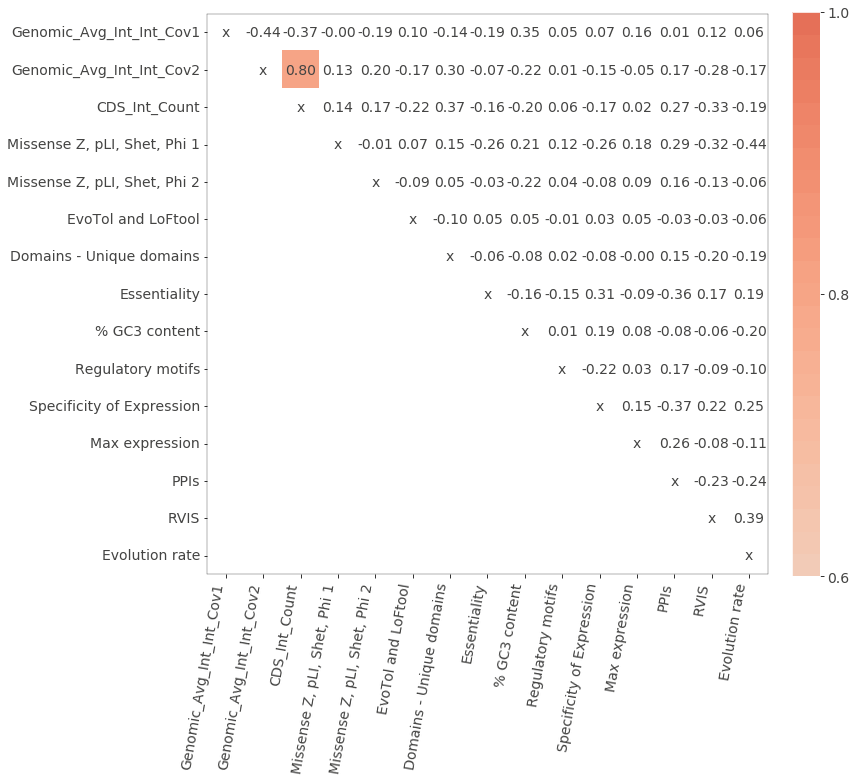

In [475]:
# maybe check for collinearity/codependence at this stage: PCA? Or look at sums of raw scores? - initial PCA
# this is PCA'd data
viz = rfpimp.plot_corr_heatmap(combiDF.iloc[:,0:15],figsize=(12,12),label_fontsize=14,value_fontsize=14)
viz.save('corr_SSD_Sing_new_round1_PCA.svg')
viz.view()

# mat = rfpimp.feature_dependence_matrix(combiDF.iloc[:,0:15])
# viz2 = rfpimp.plot_dependence_heatmap(mat,figsize=[15,10],label_fontsize=14,value_fontsize=14)
# viz2.save('dep_SSD_Sing_new_round1_PCA.svg')
# viz2.view()

In [477]:
# test/train splitting
combiDFBinary = combiDF.replace('SSD',1)
combiDFBinary = combiDFBinary.replace('singleton',0)
train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:15]], combiDFBinary[combiDFBinary.columns[15]], train_size = 0.8)

# undersampling/weighting/oversampling - all in one cell for easy switching
# undersampling
sampler = RandomUnderSampler()
train_X, train_Y  = sampler.fit_sample(train_x, train_y)

# no optimisation fit and accuracy check
rf = RandomForestClassifier()
rf.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rf.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rf.predict(test_x)))
print('F1 score: ', f1_score(test_y,rf.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('SSD recall:', tn/(tn+fp))
print('SSD precision:', tn/(tn+fn))

Overall accuracy: 0.682492581602
F1 score:  0.514372163389

Singleton recall: 0.574324324324
Singleton precision: 0.465753424658

SSD recall: 0.727272727273
SSD precision: 0.804953560372


/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [478]:
# run with PCA'd set
# test/train splitting

train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:15]], combiDFBinary[combiDFBinary.columns[15]], train_size = 0.8)

# undersampling/weighting/oversampling - all in one cell for easy switching
# undersampling
sampler = RandomUnderSampler()
train_X, train_Y  = sampler.fit_sample(train_x, train_y)
# no optimisation fit and accuracy check
rf = RandomForestClassifier()
rf.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rf.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rf.predict(test_x)))
print('F1 score: ', f1_score(test_y,rf.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

# hyperparameter selection - initial broad search followed by fine tuning
# broad search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 150, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2,n_jobs = -1,scoring='f1')
# Fit the random search model
rf_random.fit(train_X, train_Y)
print(rf_random.best_params_)

/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Overall accuracy: 0.674579624135
F1 score:  0.485133020344

Singleton recall: 0.584905660377
Singleton precision: 0.414438502674

WGD recall: 0.706434316354
WGD precision: 0.827315541601
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV] min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118, total=   1.1s
[CV]  min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118, total=   1.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV] min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=1, max_features=a

[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=4, max_features=auto,

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s


[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=5, n_estimators=54, total=   0.4s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43, total=   0.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43, total=   0.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=43 
[CV]  min_samples_leaf=4, max_fe

[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139, total=   1.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, ma

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=2, n_estimators=96, total=   1.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=2, n_estimators=96 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=2, n_estimators=96, total=   1.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=2, n_estimators=96 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=2, n_estimators=96, total=   1.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=11 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, min_samples_split=10, n_estimators=11 
[CV]  min_samples_leaf=1, max_fea

[CV]  min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.3s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.4s
[CV] min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118 


[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.1min


[CV]  min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=118, total=   2.2s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=s

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128, total=   2.4s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128, total=   2.5s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128, total=   2.6s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=128, total=   1.7s
[CV] min_samples_leaf=2, max

[CV] min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.4s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=96 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=96 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=96, total=   1.7s
[CV] min_samples_leaf=1, max_featu

[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=118, total=   2.8s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=5, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=1, max_features=sqr

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86, total=   0.9s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86, total=   0.6s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=86, total=   0.7s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=75 
[CV]  min_samples_leaf=1, max_features=s

[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=118, total=   0.9s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32, total=   0.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32, total=   0.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32, total=   0.3s
[CV] min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, min_samples_split=5, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=au

[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  3.2min


[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43, total=   0.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43, total=   0.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43, total=   0.5s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43, total=   0.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, min_samples_split=5, n_estimators=43 
[CV]  min_samples_leaf=4, ma

[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107, total=   2.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107, total=   1.8s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107, total=   1.8s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=2, n_estimators=107, total=   1.3s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=75 
[CV]  min_samples_leaf=4, ma

[CV] min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32 
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32, total=   0.4s
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32, total=   0.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32 
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32, total=   0.4s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=10, n_estimators=32 
[CV]  min_samples_leaf=1, max_features=sqrt, max_de

[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139, total=   2.0s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139, total=   2.2s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139, total=   2.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139, total=   1.9s
[CV] min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_sa

[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=2, n_estimators=32, total=   0.4s
[CV] min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=2, n_estimators=32 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=2, n_estimators=32, total=   0.3s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=2, n_estimators=32, total=   0.3s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=86, total=   0.7s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True, min_samples_split=2, n_estimators=86 
[CV]  min_samples_leaf=4, max_featur

[CV]  min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139, total=   1.7s
[CV] min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139, total=   1.6s
[CV] min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139, total=   1.5s
[CV] min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139, total=   1.6s
[CV] min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, min_samples_split=10, n_estimators=139 
[CV]  min_samples_le

[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64, total=   0.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64, total=   0.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64, total=   0.6s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=64, total=   0.9s
[CV] min_samples_lea

[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=2, n_estimators=128, total=   1.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=10, n_estimators=22, total=   0.4s
[CV] min_samples_leaf=4, max_

[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.4s
[CV] min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=118, total=   1.6s
[CV] min_samples_lea

[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  5.7min


[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118, total=   1.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118, total=   1.2s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118, total=   1.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118, total=   0.9s
[CV] min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, min_samples_split=10, n_estimators=118 
[CV]  min_sa

[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=1 
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128, total=   1.5s
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128, total=   1.6s
[CV] min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, min_samples_split=2, n_estimators=128 
[CV]  min_samples_leaf=2, max_features=auto, 

[CV]  min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, min_samples_split=5, n_estimators=107, total=   1.0s
[CV] min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1, total=   0.0s
[CV]  min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, min_samples_split=2, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=2, max_featur

[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, min_samples_split=5, n_estimators=1, total=   0.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, min_samples_split=5, n_estimators=54 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, min_samples_split=5, n_estimators=54, total=   0.7s
[CV] min_samples_leaf=1, max_features=auto, ma

[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107, total=   1.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107, total=   1.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107, total=   1.1s
[CV] min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, min_samples_split=10, n_estimators=107, total=   1.1s
[CV] min_samples_lea

[CV] min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=2, max_features=sqrt, 

[CV] min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=2, n_estimators=22, total=   0.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86, total=   1.5s
[CV] min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86, total=   1.6s
[CV] min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, min_samples_split=5, n_estimators=86, total=   1.2s
[CV] min_samples_leaf=4, max_feature

[CV] min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=2, n_estimators=22, total=   0.3s
[CV]  min_samples_leaf=4, max_featur

[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV] min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=22 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, min_samples_split=2, n_estimators=22, total=   0.2s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=1, total=   0.0s
[CV] min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, min_samples_split=10, n_estimators=1 
[CV]  min_samples_leaf=4, max_features=sqrt, ma

[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22, total=   0.3s
[CV] min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, min_samples_split=5, n_estimators=22 
[CV]  min_samples_leaf=1, max_featur

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  8.0min finished


{'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False, 'min_samples_split': 10, 'n_estimators': 118}


In [479]:
# PCA'd data, after broad search
# # from sklearn.metrics import f1_score
# rfBestSSD = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=110, max_features='sqrt', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=2, min_samples_split=5,
#             min_weight_fraction_leaf=0.0, n_estimators=54, n_jobs=1,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)
rfBestSSD = rf_random.best_estimator_
rfBestSSD.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestSSD.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestSSD.predict(test_x)))
print('F1 score: ',f1_score(test_y,rfBestSSD.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('WGD recall:', tn/(tn+fp))
print('WGD precision:', tn/(tn+fn))

Overall accuracy: 0.663699307616
F1 score:  0.51566951567

Singleton recall: 0.683018867925
Singleton precision: 0.414187643021

WGD recall: 0.656836461126
WGD precision: 0.853658536585


In [480]:
# PCA
# more refined search
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 130, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(40,60, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [9,10,11]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2,n_jobs = -1,scoring='f1')
# Fit the random search model
rf_random.fit(train_X, train_Y)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107 
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split=5, n_estimators=107, total=   0.8s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=51, bootstrap=True, min_samples_split

[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.2s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.1s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.2s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.2s
[CV] min_samples_lea

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.8s


[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.3s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=None, bootstrap=False, min_samples_split=4, n_estimators=109 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=130, total=   1.1s
[CV] min_samples_leaf=9, max_features=auto, max_depth=None, bootstrap=False, min_samples_split=4, n_estimators=109 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=None, bootstrap=False, min_samples_split=4, n_estimators=109, total=   1.0s
[CV] min_samples_leaf=9, max_features=auto, max_depth=None, bootstrap=False, min_samples_split=4, n_estimators=109 
[CV]  min_sample

[CV]  min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=11, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=11, m

[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=10, max_features=auto, max_depth=45, bootstrap=True, min_samples_split=5, n_estimators=122 
[CV]  min_samples_lea

[CV] min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=109, total=   1.0s
[CV] min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104, total=   0.7s
[CV] min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104, total=   0.7s
[CV] min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=104, total=   0.7s
[CV] min_samples_leaf=10, m

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min


[CV]  min_samples_leaf=10, max_features=auto, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103, total=   0.7s
[CV] min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103, total=   0.7s
[CV] min_samples_leaf=10, max_features=auto, max_depth=43, bootstrap=True, min_samples_split=4, n_estimators=103 
[CV]  min_samples_leaf=10, m

[CV]  min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101, total=   1.5s
[CV] min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101, total=   1.3s
[CV] min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101, total=   0.9s
[CV] min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101, total=   0.9s
[CV] min_samples_leaf=11, max_features=auto, max_depth=57, bootstrap=False, min_samples_split=5, n_estimators=101 
[CV]  min_samples_le

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103, total=   0.9s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103, total=   1.0s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=55, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=42, bootstrap=False, min_samples_split=3, n_estimators=103, total=   1.0s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=55, bootstrap=True, min_samples_split=4, n_estimators=118 
[CV]  min_samples_leaf=9, max_

[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106, total=   2.1s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106, total=   2.1s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106, total=   1.8s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106, total=   1.5s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=106 
[CV]  min_samples_le

[CV] min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130, total=   1.2s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130, total=   1.5s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130, total=   1.8s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=49, bootstrap=False, min_samples_split=3, n_estimators=130, total=   1.6s
[CV] min_samples_lea

[CV] min_samples_leaf=11, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=122 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=122, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=106 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=122, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=106 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=106, total=   0.7s
[CV] min_samples_leaf=9, max_features=auto, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=106 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=106, total=   0.7s
[CV] min_samples_leaf=9, ma

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.3min


[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=48, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=11, m

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112, total=   0.8s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112, total=   1.1s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=4, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=53, bootstrap=False, min_samples_split=4, n_estimators=126 
[CV]  min_samples_le

[CV]  min_samples_leaf=9, max_features=auto, max_depth=49, bootstrap=False, min_samples_split=4, n_estimators=107, total=   1.4s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103, total=   1.0s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103, total=   1.1s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103, total=   1.1s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=3, n_estimators=103 
[CV]  min_samples_leaf=9, max_featu

[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106, total=   1.1s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106, total=   0.9s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=True, min_samples_split=5, n_estimators=106 
[CV]  min_sa

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=48, bootstrap=False, min_samples_split=5, n_estimators=114, total=   1.7s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=48, bootstrap=False, min_samples_split=5, n_estimators=114 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=48, bootstrap=False, min_samples_split=5, n_estimators=114, total=   1.6s
[CV] min_samples_leaf=11, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=3, n_estimators=122 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=48, bootstrap=False, min_samples_split=5, n_estimators=114, total=   1.5s
[CV] min_samples_leaf=11, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=3, n_estimators=122 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=3, n_estimators=122, total=   1.7s
[CV] min_samples_leaf=11, max_features=auto, max_depth=60, bootstrap=False, min_samples_split=3, n_estimators=122 
[CV]  min_samples_leaf=1

[CV]  min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115, total=   1.1s
[CV] min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=115 
[CV]  min_samples_leaf=9, max_featur

[CV]  min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.8s
[CV] min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.8s
[CV] min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.8s
[CV] min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=auto, max_depth=57, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.8s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=56, bootstrap=False, min_samples_split=4, n_estimators=107 
[CV]  min_samples_leaf=10, 

[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=52, bootstrap=True, min_samples_split=5, n_estimators=115, total=   0.8s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112, total=   1.3s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=52, bootstrap=False, min_samples_split=4, n_estimators=112 
[CV]  min_samples_lea

[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=54, bootstrap=True, min_samples_split=3, n_estimators=111 
[CV]  min_samples_leaf=10, m

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.5min


[CV]  min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115, total=   1.6s
[CV] min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115, total=   1.0s
[CV] min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115, total=   1.0s
[CV] min_samples_leaf=9, max_features=auto, max_depth=40, bootstrap=False, min_samples_split=3, n_estimators=115 
[CV]  min_samples_leaf=9, ma

[CV]  min_samples_leaf=11, max_features=auto, max_depth=44, bootstrap=False, min_samples_split=3, n_estimators=117, total=   1.0s
[CV] min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=44, bootstrap=False, min_samples_split=3, n_estimators=117, total=   1.0s
[CV] min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=41, bootstrap=True, min_samples_split=5, n_estimators=120 
[CV]  min_samples_leaf=9, max_fe

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123, total=   0.8s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123, total=   0.9s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123, total=   0.9s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123, total=   0.8s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=40, bootstrap=True, min_samples_split=4, n_estimators=123 
[CV]  min_samples_leaf=9, max_featur

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112, total=   1.4s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112, total=   1.3s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=104 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=40, bootstrap=False, min_samples_split=5, n_estimators=104 
[CV]  min_samples_leaf=10,

[CV]  min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118, total=   0.9s
[CV] min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118, total=   0.9s
[CV] min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118, total=   0.8s
[CV] min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118, total=   1.3s
[CV] min_samples_leaf=11, max_features=auto, max_depth=48, bootstrap=True, min_samples_split=5, n_estimators=118 
[CV]  min_samples_leaf=11, m

[CV]  min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104, total=   1.2s
[CV] min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104, total=   1.4s
[CV] min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104, total=   1.3s
[CV] min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104, total=   1.3s
[CV] min_samples_leaf=9, max_features=auto, max_depth=47, bootstrap=False, min_samples_split=3, n_estimators=104 
[CV]  min_samples_leaf=9, ma

[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=107, total=   0.7s
[CV] min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120 
[CV]  min_samples_leaf=11, max_features=sqrt, max_depth=44, bootstrap=True, min_samples_split=4, n_estimators=107, total=   0.7s
[CV] min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120, total=   1.1s
[CV] min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120, total=   1.1s
[CV] min_samples_leaf=9, max_features=auto, max_depth=50, bootstrap=False, min_samples_split=3, n_estimators=120 
[CV]  min_samples_leaf=9, ma

[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112, total=   0.8s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112, total=   0.8s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112, total=   0.9s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112 
[CV]  min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112, total=   1.0s
[CV] min_samples_leaf=9, max_features=sqrt, max_depth=58, bootstrap=True, min_samples_split=5, n_estimators=112 
[CV]  min_samples_leaf=9, max_featur

[CV]  min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122, total=   1.0s
[CV] min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122, total=   1.0s
[CV] min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122, total=   1.0s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=44, bootstrap=False, min_samples_split=4, n_estimators=100 
[CV]  min_samples_leaf=11, max_features=auto, max_depth=55, bootstrap=False, min_samples_split=5, n_estimators=122, total=   1.1s
[CV] min_samples_leaf=11, max_features=sqrt, max_depth=44, bootstrap=False, min_samples_split=4, n_estimators=100 
[CV]  min_samples_le

[CV]  min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128 
[CV]  min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128, total=   0.8s
[CV] min_samples_leaf=9, max_features=auto, max_depth=56, bootstrap=True, min_samples_split=4, n_estimators=128 
[CV]  min_samples_leaf=9, max_featur

[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100 
[CV]  min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100, total=   0.7s
[CV] min_samples_leaf=10, max_features=sqrt, max_depth=53, bootstrap=True, min_samples_split=4, n_estimators=100 
[CV]  min_samples_leaf=10, m

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.7min finished


{'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 48, 'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 114}


In [481]:
# PCA'd data, after refined search
rfBestSSDmaybe = rf_random.best_estimator_
rfBestSSDmaybe.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestSSDmaybe.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestSSDmaybe.predict(test_x)))
print('F1 score: ',f1_score(test_y,rfBestSSDmaybe.predict(test_x)))
print('')
print('Singleton recall:', tp/(tp+fn))
print('Singleton precision:', tp/(tp+fp))
print('')
print('SSD recall:', tn/(tn+fp))
print('SSD precision:', tn/(tn+fn))

Overall accuracy: 0.668644906034
F1 score:  0.517985611511

Singleton recall: 0.679245283019
Singleton precision: 0.418604651163

SSD recall: 0.664879356568
SSD precision: 0.853700516351


In [482]:
# current best SSD model parameters
rfBestSSD = rfBestSSDmaybe
print(rfBestSSD)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=48, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=114, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [483]:
# initial run: look for negative importances: refined 1st run
rfBestSSD.fit(train_X,train_Y)

tn, fp, fn, tp = confusion_matrix(test_y, rfBestSSD.predict(test_x)).ravel()

print('Overall accuracy:', accuracy_score(test_y,rfBestSSD.predict(test_x)))
print('Singleton accuracy:', tp/(tp+fn))
print('WGD accuracy:', tn/(tn+fp))

Overall accuracy: 0.668644906034
Singleton accuracy: 0.683018867925
WGD accuracy: 0.663538873995


In [489]:
# check feature importances for selected hyperparameters: PCA'd data
    
rankingDict = {}
for feature in combiDFBinary.columns[:15]:
    rankingDict[feature] = []
impDict = {}
for feature in combiDFBinary.columns[:15]:
    impDict[feature] = []
impDict['Sum Gen. length 2/CDS length'] = []
rankingDict['Sum Gen. length 2/CDS length'] = []
for i in range(10):
    sampler = RandomUnderSampler()
    train_x, test_x, train_y, test_y = train_test_split(combiDFBinary[combiDFBinary.columns[:15]], combiDFBinary[combiDFBinary.columns[15]], train_size = 0.8)
    train_X, train_Y  = sampler.fit_sample(train_x, train_y)

    rfBestSSD.fit(train_X,train_Y)
     
    imps = list(rfpimp.importances(rfBestSSD,test_x,test_y).itertuples(name=None))
    imps.append(('Sum Gen. length 2/CDS length', sum([x[1] for x in imps if x[0] == 'Genomic_Avg_Int_Int_Cov2' or x[0] == 'CDS_Int_Count'])))
    imps = sorted(imps,key= lambda x: x[1],reverse=True)
    feats = list(combiDFBinary.columns[:15])
    feats.append('Sum Gen. length 2/CDS length')
    for feature in feats:
        rank = [x[0] for x in imps].index(feature) + 1
        rankingDict[feature].append(rank)
        impDict[feature].append([x[1] for x in imps if x[0] == feature][0])
rankDict = {'Genomic_Avg_Int_Int_Cov1':[], 'Genomic_Avg_Int_Int_Cov2':[],
            'CDS_Int_Count':[], 'Missense Z, pLI, Shet, Phi 1':[], 'Missense Z, pLI, Shet, Phi 2':[], 
            'EvoTol and LoFtool':[],'Domains - Unique domains':[], '% GC3 content':[],
       'Essentiality':[], 'Regulatory motifs':[], 'Specificity of Expression':[],
       'Max expression':[], 'PPIs':[], 'RVIS':[], 'Evolution rate':[],'Sum Gen. length 2/CDS length':[]}
for f in rankingDict:
    rankDict[f].append(np.mean(rankingDict[f]))
    rankDict[f].append(np.std(rankingDict[f]))
print(rankDict)
print('')
for f in impDict:
    print(f, np.mean(impDict[f]))

/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/zoevance/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_siz

{'Domains - Unique domains': [2.7999999999999998, 1.2489995996796797], 'Missense Z, pLI, Shet, Phi 2': [9.5999999999999996, 3.1368774282716245], 'Genomic_Avg_Int_Int_Cov1': [12.300000000000001, 2.6851443164195103], 'Missense Z, pLI, Shet, Phi 1': [10.4, 2.5768197453450252], '% GC3 content': [10.699999999999999, 4.5836666545463363], 'PPIs': [5.0, 2.4083189157584592], 'Specificity of Expression': [1.0, 0.0], 'Evolution rate': [10.9, 3.8327535793473597], 'Sum Gen. length 2/CDS length': [5.5, 2.8017851452243798], 'RVIS': [12.6, 3.3226495451672298], 'CDS_Int_Count': [7.4000000000000004, 3.5552777669262356], 'Max expression': [10.699999999999999, 2.8301943396169813], 'Regulatory motifs': [12.199999999999999, 1.6613247725836149], 'Essentiality': [9.5, 5.0842895275544651], 'Genomic_Avg_Int_Int_Cov2': [9.5999999999999996, 2.9393876913398138], 'EvoTol and LoFtool': [5.7999999999999998, 3.2496153618543842]}

Domains - Unique domains 0.0210682492582
Missense Z, pLI, Shet, Phi 2 0.0055390702275
Gen

In [487]:
combiDFBinary.columns

Index(['Genomic_Avg_Int_Int_Cov1', 'Genomic_Avg_Int_Int_Cov2', 'CDS_Int_Count',
       'Missense Z, pLI, Shet, Phi 1', 'Missense Z, pLI, Shet, Phi 2',
       'EvoTol and LoFtool', 'Domains - Unique domains', 'Essentiality',
       '% GC3 content', 'Regulatory motifs', 'Specificity of Expression',
       'Max expression', 'PPIs', 'RVIS', 'Evolution rate', 'dupType'],
      dtype='object')

In [406]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['Genomic_Avg_Int_Int_Cov1']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Average intron length', -0.96347733266767166),
 ('Genomic length', -0.93971633310413905),
 ('Intron coverage', -0.86439485185548159),
 ('% GC content', 0.53502962204630689),
 ('Intron count', -0.36821862567616032),
 ('% GC3 content', 0.3523341478713185),
 ('CDS length', -0.31286573735917228),
 ('Essentiality', -0.19070193833892021),
 ('Max expression', 0.15673227905727277),
 ('Domains', -0.14177778908399957),
 ('Transcript isoforms count', -0.12870922687730851),
 ('Phi', -0.12637321102526092),
 ('Unique domains', -0.12482144809946294),
 ('RVIS', 0.11832475549431228),
 ('S_het', -0.11690184743719936),
 ('EvoTol', -0.097486149217528406),
 ('Specificity of Expression', 0.073088621878738713),
 ('pLI', -0.069431659632776824),
 ('Evolution rate', 0.06002068711255075),
 ('Regulatory motifs', 0.044504282137209902),
 ('LoFtool', 0.026692847457651984),
 ('PPIs', 0.0060803913144639038),
 ('Missense Z score', 0.0039143060113254963)]

In [407]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['Genomic_Avg_Int_Int_Cov2']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Intron count', 0.79768068679723181),
 ('Genomic length', 0.68642161274347457),
 ('CDS length', 0.652345077508239),
 ('Intron coverage', 0.44890528878663427),
 ('Transcript isoforms count', 0.30160563811789237),
 ('Domains', 0.29511518406170539),
 ('RVIS', -0.28203211544633422),
 ('Unique domains', 0.28022544736220611),
 ('% GC content', -0.27183120782272208),
 ('Average intron length', 0.22943961949541164),
 ('% GC3 content', -0.21601133578447021),
 ('S_het', 0.20276656065384244),
 ('Phi', 0.18709884109034763),
 ('PPIs', 0.17344016301218954),
 ('EvoTol', 0.1706684056152018),
 ('Evolution rate', -0.16906881063997592),
 ('Specificity of Expression', -0.14445911243298318),
 ('Missense Z score', 0.12160273733687665),
 ('pLI', 0.086135999128816296),
 ('Essentiality', -0.070189954128530394),
 ('LoFtool', -0.05943645937489183),
 ('Max expression', -0.051496463534785611),
 ('Regulatory motifs', 0.0064263206097851236)]

In [408]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['CDS_Int_Count']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Intron count', 0.99899308797309128),
 ('CDS length', 0.75152745288320011),
 ('Genomic length', 0.60071049133469667),
 ('Transcript isoforms count', 0.46730144160686449),
 ('Intron coverage', 0.38426528847430191),
 ('Domains', 0.37185010783025879),
 ('Unique domains', 0.35798671043389546),
 ('RVIS', -0.32574309866854534),
 ('PPIs', 0.267371792720907),
 ('EvoTol', 0.21702245401886311),
 ('% GC3 content', -0.19772567035829783),
 ('% GC content', -0.186675729465895),
 ('Evolution rate', -0.18572074925484447),
 ('S_het', 0.17295852450154814),
 ('Specificity of Expression', -0.17291232584596208),
 ('Phi', 0.17009409299005362),
 ('Essentiality', -0.16270199112889025),
 ('Average intron length', 0.15325025844412898),
 ('Missense Z score', 0.13686368104709265),
 ('Regulatory motifs', 0.058190525094089014),
 ('pLI', 0.039637171294451247),
 ('Max expression', 0.024094161225539298),
 ('LoFtool', -0.013097037081636223)]

In [409]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['Missense Z, pLI, Shet, Phi 1']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Missense Z score', 0.99876665423137101),
 ('pLI', 0.60853410008436071),
 ('S_het', 0.58608278343521136),
 ('Phi', 0.52011860891394313),
 ('LoFtool', -0.4559601463115795),
 ('Evolution rate', -0.44426666284393684),
 ('RVIS', -0.32321146407488111),
 ('PPIs', 0.2920139947175695),
 ('Specificity of Expression', -0.26434082506362006),
 ('Essentiality', -0.25725420357500156),
 ('% GC3 content', 0.21437933569887505),
 ('Max expression', 0.18398333140885692),
 ('% GC content', 0.15895638869902859),
 ('Domains', 0.1463089796316363),
 ('Unique domains', 0.14628157503952077),
 ('Intron count', 0.14270250564769185),
 ('CDS length', 0.13763036862927272),
 ('Regulatory motifs', 0.12410880841422318),
 ('EvoTol', -0.073457397605034003),
 ('Transcript isoforms count', 0.061775760768574155),
 ('Genomic length', 0.053067586592774829),
 ('Average intron length', -0.03471177561034311),
 ('Intron coverage', -0.030324930469782907)]

In [410]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['Missense Z, pLI, Shet, Phi 2']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Phi', 0.6082934094344411),
 ('pLI', 0.57592290199085261),
 ('S_het', 0.53944670734184508),
 ('LoFtool', -0.31956581482358792),
 ('Genomic length', 0.22273551267069622),
 ('% GC3 content', -0.22264153021960953),
 ('% GC content', -0.20256963158053243),
 ('CDS length', 0.18381272392598255),
 ('Intron count', 0.16811529114340279),
 ('PPIs', 0.15936990014750352),
 ('Average intron length', 0.15578940047432172),
 ('Intron coverage', 0.13409738711377156),
 ('RVIS', -0.12759648428627116),
 ('EvoTol', 0.09197575319916805),
 ('Max expression', 0.091887474311257475),
 ('Specificity of Expression', -0.079641300930830078),
 ('Evolution rate', -0.064066802156940286),
 ('Missense Z score', -0.049177992716086513),
 ('Domains', 0.048546248264680042),
 ('Unique domains', 0.044465852848486198),
 ('Transcript isoforms count', 0.036903499358804173),
 ('Regulatory motifs', 0.035737960723337729),
 ('Essentiality', -0.02554314708026776)]

In [411]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['Domains - Unique domains']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('Domains', 0.99785404457394677),
 ('Unique domains', 0.91500894581967052),
 ('CDS length', 0.44881766998432254),
 ('Intron count', 0.36408532441761554),
 ('Genomic length', 0.22860984463864606),
 ('RVIS', -0.20317773042687273),
 ('Evolution rate', -0.18771675624163198),
 ('PPIs', 0.14564543593710666),
 ('Missense Z score', 0.14467938548544876),
 ('Transcript isoforms count', 0.10690808852059176),
 ('S_het', 0.10679797645982601),
 ('EvoTol', 0.096495641084345093),
 ('Phi', 0.092898403080242428),
 ('Intron coverage', 0.090736588868584211),
 ('Specificity of Expression', -0.082026015737556204),
 ('% GC3 content', -0.077972261556191608),
 ('% GC content', -0.072095518311399737),
 ('Average intron length', 0.061062999729089448),
 ('Essentiality', -0.061052368792681555),
 ('LoFtool', -0.048811907111346281),
 ('pLI', 0.036576035919047685),
 ('Regulatory motifs', 0.024002395492407395),
 ('Max expression', -0.0048481833658903569)]

In [412]:
corrList = []
for c in df.columns[:23]:
    corrList.append((c,spearmanr(df[c],combiDF['GC_GC3']).correlation))
corrList.sort(key=lambda x: abs(x[1]),reverse=True)
corrList

[('% GC content', 0.99999977404107376),
 ('% GC3 content', 0.83580320541968844),
 ('Genomic length', -0.5211578338575219),
 ('Average intron length', -0.51189814351133023),
 ('Intron coverage', -0.48171587440309382),
 ('Essentiality', -0.25051327729621686),
 ('Intron count', -0.18569367366710382),
 ('Missense Z score', 0.16739476241626103),
 ('CDS length', -0.15659016506965198),
 ('Max expression', 0.11839929739725899),
 ('Evolution rate', -0.10494160318786662),
 ('LoFtool', -0.089875431358738961),
 ('Specificity of Expression', 0.08426485687105327),
 ('Regulatory motifs', 0.082863083152829989),
 ('Domains', -0.071465328498284589),
 ('Unique domains', -0.066812713663288184),
 ('S_het', -0.05648095705406881),
 ('Phi', -0.035616895618874815),
 ('EvoTol', -0.033840682008309107),
 ('RVIS', -0.028546680465492275),
 ('pLI', -0.021914690733228593),
 ('Transcript isoforms count', -0.003301953444086275),
 ('PPIs', 0.0011295582178247039)]